In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal
import os
import requests
import tarfile
from scipy.io import wavfile

# Download LJ Speech Dataset
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

# Extract only the first 30 WAV files
download_dir = "LJSpeech-1.1"
os.makedirs(download_dir, exist_ok=True)

with tarfile.open("LJSpeech-1.1.tar.bz2", "r:bz2") as file:
    count = 0
    for member in file.getmembers():
        if member.name.endswith(".wav") and count < 30:
            file.extract(member, path=".")
            count += 1
        if count >= 30:
            break

print(f"Downloaded 30 audio samples to: {download_dir}")



--2025-05-04 09:38:49--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 143.244.50.83, 2400:52e0:1a01::987:1
Connecting to data.keithito.com (data.keithito.com)|143.244.50.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘LJSpeech-1.1.tar.bz2.2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G   102MB/s    in 38s     

2025-05-04 09:39:28 (68.4 MB/s) - ‘LJSpeech-1.1.tar.bz2.2’ saved [2748572632/2748572632]

Downloaded 30 audio samples to: LJSpeech-1.1


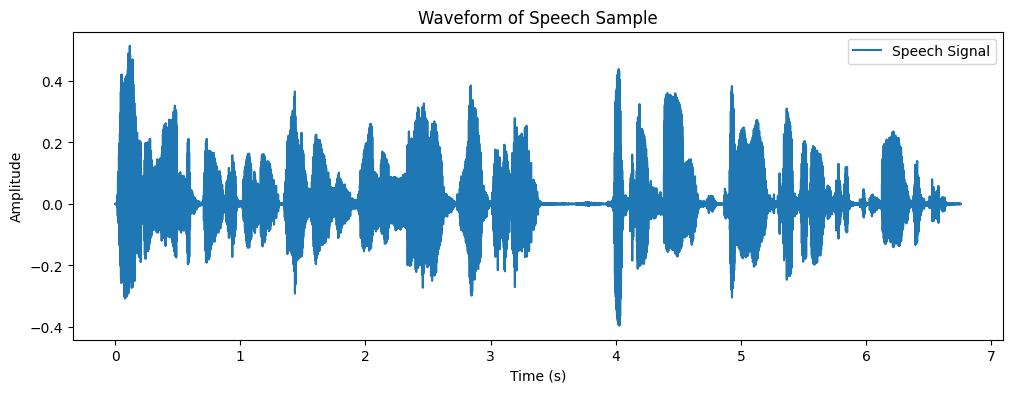

In [ ]:
# Select a sample file
sample_file = "/content/LJSpeech-1.1/wavs/LJ036-0043.wav"
signal, sr = librosa.load(sample_file, sr=16000)
# Plot waveform
time = np.linspace(0, len(signal) / sr, num=len(signal))
plt.figure(figsize=(12, 4))
plt.plot(time, signal, label='Speech Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of Speech Sample')
plt.legend()
plt.show()

In [ ]:
def autocorrelation_pitch(signal, sample_rate):
    autocorr = correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    peak = np.argmax(autocorr[1:]) + 1
    return sample_rate / peak if peak > 0 else 0

In [ ]:
def amdf_pitch(signal, frame_size, sample_rate):
    amdf = []
    for tau in range(1, frame_size):
        diff = np.sum(np.abs(signal[:-tau] - signal[tau:]))
        amdf.append(diff)
    min_tau = np.argmin(amdf) + 1
    return sample_rate / min_tau if min_tau > 0 else 0


In [ ]:
def asm_df_pitch(signal, frame_size, sample_rate):
    asm_df = []
    for tau in range(1, frame_size):
        diff = np.sum(np.abs(signal[:-tau] - signal[tau:])) / (len(signal) - tau)
        asm_df.append(diff)
    min_tau = np.argmin(asm_df) + 1
    return sample_rate / min_tau if min_tau > 0 else 0


In [ ]:
def fft_pitch(signal, sample_rate):
    spectrum = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(spectrum), 1 / sample_rate)
    magnitude = np.abs(spectrum)
    half = len(freqs) // 2
    peak = np.argmax(magnitude[:half])
    return freqs[peak] if peak > 0 else 0


In [ ]:
from scipy.signal import correlate
frame_size = 1024
sample_rate = 16000
pitch_autocorr =  autocorrelation_pitch(signal[:frame_size], sample_rate)
pitch_amdf = amdf_pitch(signal[:frame_size], frame_size, sample_rate)
pitch_asmdf = asm_df_pitch(signal[:frame_size], frame_size, sample_rate)
pitch_fft = fft_pitch(signal[:frame_size], sample_rate)
print(f"Autocorrelation Pitch: {pitch_autocorr:.2f} Hz")
print(f"AMDF Pitch: {pitch_amdf:.2f} Hz")
print(f"ASMDF Pitch: {pitch_asmdf:.2f} Hz")
print(f"FFT Pitch: {pitch_fft:.2f} Hz")

Autocorrelation Pitch: 16000.00 Hz
AMDF Pitch: 15.64 Hz
ASMDF Pitch: 15.66 Hz
FFT Pitch: 546.88 Hz


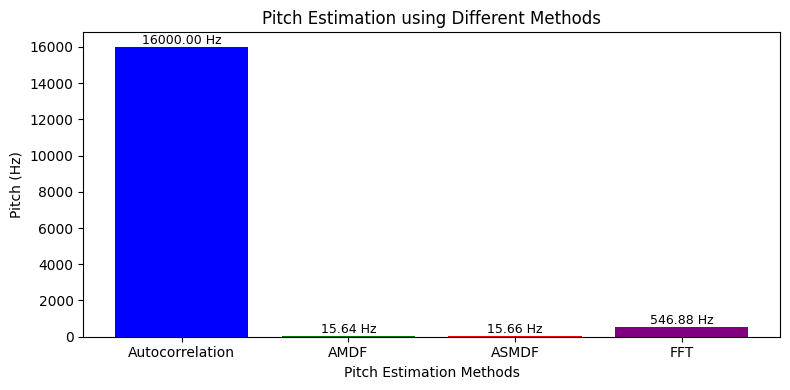

In [ ]:
methods = ["Autocorrelation", "AMDF", "ASMDF", "FFT"]
pitches = [pitch_autocorr, pitch_amdf, pitch_asmdf, pitch_fft]
colors = ['blue', 'green', 'red', 'purple']

plt.figure(figsize=(8, 4))
bars = plt.bar(methods, pitches, color=colors)

for bar, pitch in zip(bars, pitches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{pitch:.2f} Hz',
             ha='center', va='bottom', fontsize=9)
plt.xlabel("Pitch Estimation Methods")
plt.ylabel("Pitch (Hz)")
plt.title("Pitch Estimation using Different Methods")
plt.tight_layout()
plt.show()

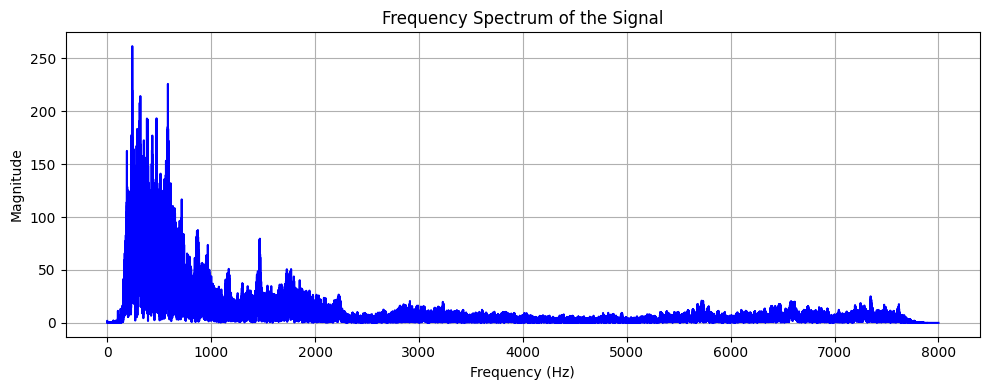

In [ ]:
fft_result = np.fft.fft(signal)

frequency_bins = np.fft.fftfreq(len(fft_result), d=1/sample_rate)

magnitude_spectrum = np.abs(fft_result)

positive_frequencies = frequency_bins[:len(frequency_bins) // 2]
positive_magnitudes = magnitude_spectrum[:len(magnitude_spectrum) // 2]

plt.figure(figsize=(10, 4))
plt.plot(positive_frequencies, positive_magnitudes, color='blue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of the Signal')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

fft_spectrum = fft_result

magnitude = np.abs(fft_spectrum)
half_spectrum = magnitude[:len(frequency_bins) // 2]
half_freqs = frequency_bins[:len(frequency_bins) // 2]
top_indices = np.argsort(half_spectrum)[-5:]
top_frequencies = half_freqs[top_indices]
top_frequencies = np.sort(top_frequencies)
print("Top Harmonic Frequencies (Hz):")
for freq in top_frequencies:
    print(f"{freq:.2f} Hz")

Top Harmonic Frequencies (Hz):
239.32 Hz
240.80 Hz
241.24 Hz
318.84 Hz
584.22 Hz


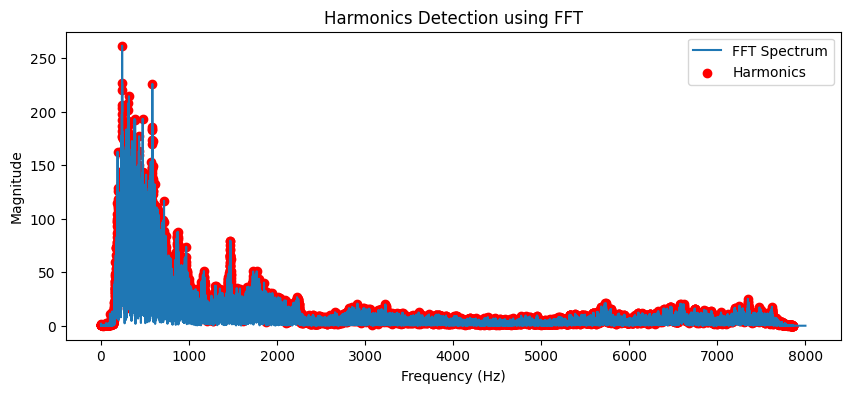

In [ ]:
freqs = frequency_bins
magnitude = magnitude_spectrum
peaks, _ = find_peaks(magnitude[:len(magnitude)//2], prominence=0.1)
plt.figure(figsize=(10, 4))
plt.plot(freqs[:len(freqs)//2], magnitude[:len(magnitude)//2], label="FFT Spectrum")
plt.scatter(freqs[peaks], magnitude[peaks], color='red', label="Harmonics")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Harmonics Detection using FFT')
plt.legend()
plt.show()


Estimated Formant Frequencies (Hz):
Formant 1: 240.80 Hz
Formant 2: 241.24 Hz
Formant 3: 584.22 Hz


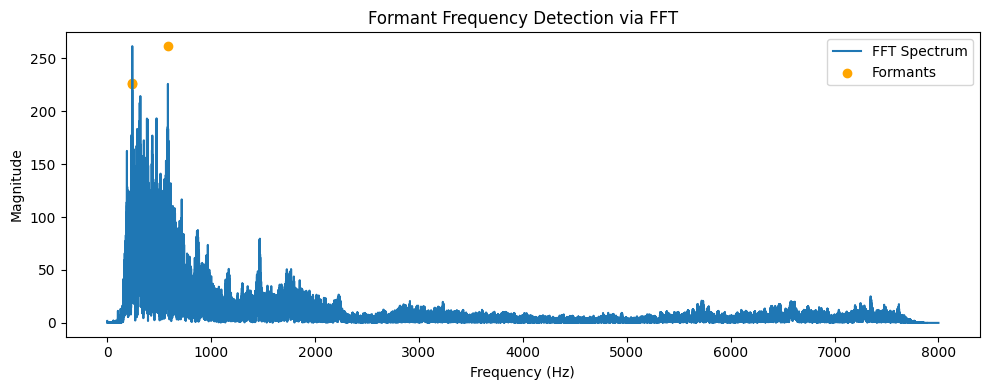

In [ ]:
num_formants = 3

positive_freqs = frequency_bins[:len(frequency_bins) // 2]
positive_magnitude = magnitude[:len(magnitude) // 2]

formant_indices = np.argsort(positive_magnitude)[-num_formants:]

formant_freqs = positive_freqs[formant_indices]

formant_freqs = np.sort(formant_freqs)

print("Estimated Formant Frequencies (Hz):")
for idx, freq in enumerate(formant_freqs, start=1):
    print(f"Formant {idx}: {freq:.2f} Hz")

plt.figure(figsize=(10, 4))
plt.plot(positive_freqs, positive_magnitude, label='FFT Spectrum')
plt.scatter(formant_freqs, positive_magnitude[formant_indices], color='orange', label='Formants')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Formant Frequency Detection via FFT')
plt.legend()
plt.tight_layout()
plt.show()

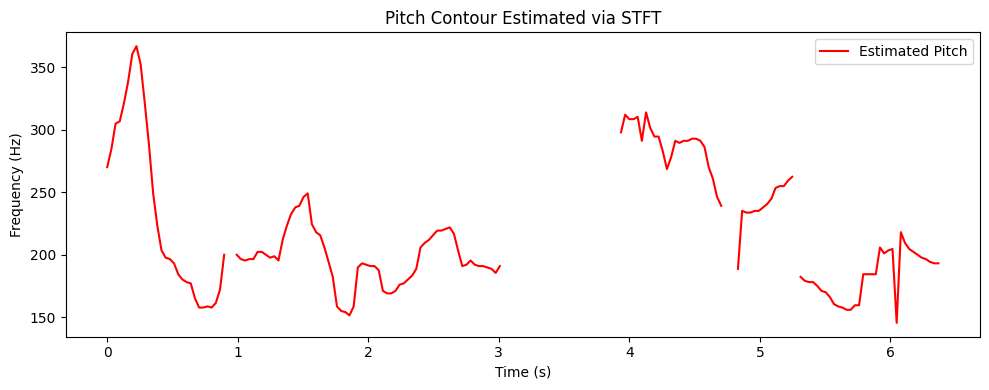

In [ ]:
f0, voiced_flag, voiced_probs = librosa.pyin(
    signal,
    fmin=50,
    fmax=500,
    sr=sample_rate
)

time_stamps = librosa.times_like(f0, sr=sample_rate)

# Plot the pitch contour over time
plt.figure(figsize=(10, 4))
plt.plot(time_stamps, f0, color='red', label='Estimated Pitch')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Contour Estimated via STFT')
plt.legend()
plt.tight_layout()
plt.show()

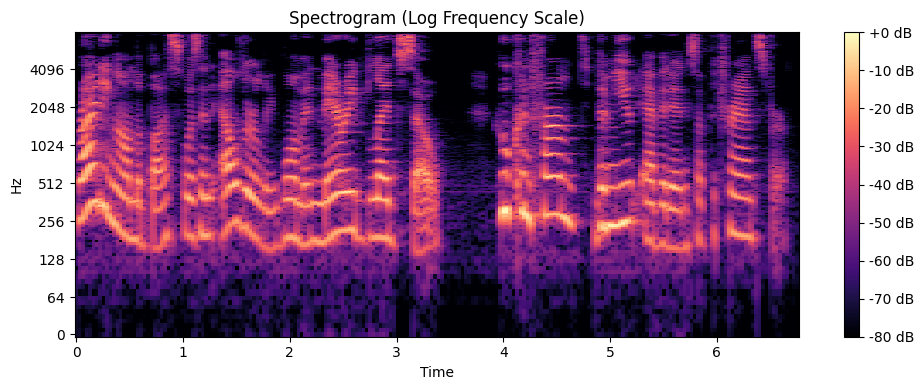

In [ ]:
stft_result = librosa.stft(signal)
magnitude = np.abs(stft_result)
magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(magnitude_db, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (Log Frequency Scale)')
plt.tight_layout()
plt.show()